In [102]:
from __future__ import print_function

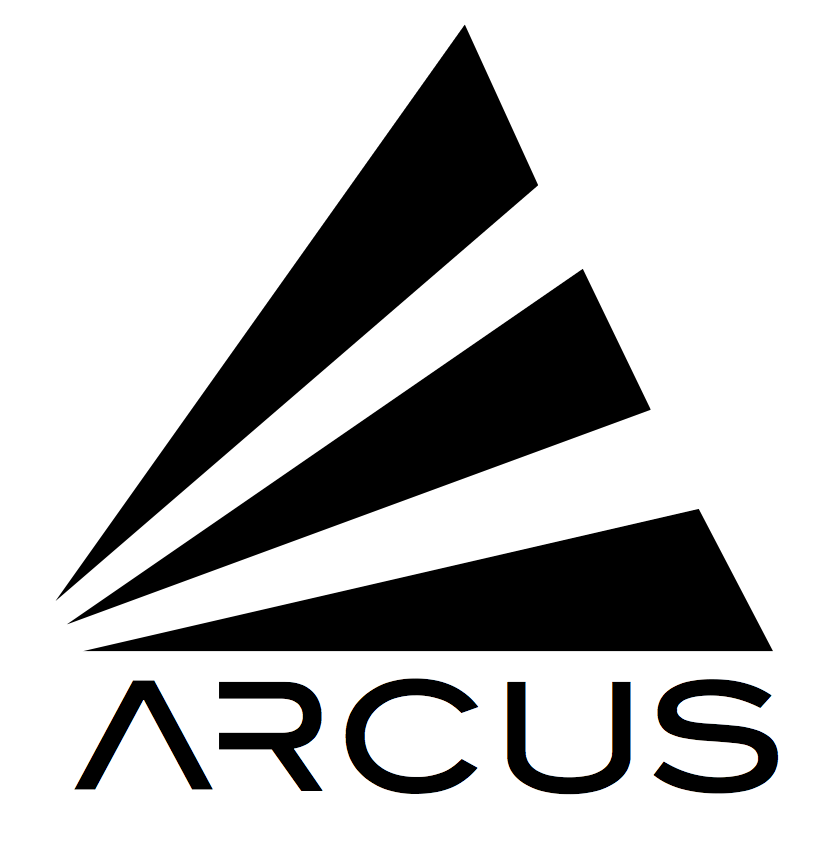

### Revision status: *in development*
Last revision in version control:

- Author: Hans Moritz Guenther <hgunther@mit.edu>
- commit 0a7b2039edeb5baa8a227c3e02a1f0910c31b4d3
- Date:   Tue Sep 19 17:16:28 2017 -0400

**The version shown here is modified compared to the last commited revision.**

            

This document is git version controlled. The repository is available at https://github.com/hamogu/arcus.
See git commit log for full revision history.

Code was last run with:

- MARXS ray-trace code version 1.2.dev608 (commit hash: e5a2daf828 from 2017-09-19)
- ARCUS python code version 0.0.dev93 (commit hash: 34fd23cb97 from 2017-09-18)
- ARCUS CALDB version hash: 98b1481 (commited on 2017-08-19 )


In [103]:
from nbtemplate import display_header, display_codetoggle, get_path
display_header('SelectRowlandParameters.ipynb', status='in development')

In [104]:
import os
import sys
from glob import glob
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
import astropy.units as u

from marxs.analysis import gratings as anagrat

%matplotlib inline

In [105]:
filelist = glob(os.path.join(get_path('grid2designtorus'), '*.fits'))

Reading config file with path definitions: ['../site.cfg']


In [106]:
filelist.sort()  # for display purposes. Also, makes the order more predictable
len(filelist)

55

In [107]:
def zero_pos(p, coord='circ_phi'):
    ind = (p['order'] == 0) & np.isfinite(p[coord])
    return np.mean(p[coord][ind])

def angle_covered_by_CCDs(p, n_ccds=8):
    return n_ccds * 49.5 / p.meta['CIRCLE_R']

In [108]:
def add_phifolded(p):
    # calculate which angles can be covered
    p.meta['phi_0'] = zero_pos(p)

    # phi at the point excatly half-way between the two channels, the "middle"
    p.meta['phi_m'] = p.meta['phi_0'] - np.arcsin(p.meta['D_CHAN'] / 2 / p.meta['CIRCLE_R'])
    
    # Distance fomr middle to 0
    p.meta['dphi_0m'] = abs(p.meta['phi_0'] - p.meta['phi_m'])

    # make new column "distance from phi_m"
    p['phi_folded'] = np.abs(p['circ_phi'] - p.meta['phi_m'])

In [109]:
def plot_phi_hist(ax, p):
    p_order = p['order', 'phi_folded', 'probability'].group_by('order')
    bins = np.linspace(0, .19, 41)
    sl = slice(-1, 2, -1)
    phis = [g['phi_folded'] for g in p_order.groups]
    probs = [g['probability'] for g in p_order.groups]
    ax.hist(phis[sl], weights=probs[sl], bins=bins, stacked=True, 
            label=[np.int(np.abs(k[0])) for k in p_order.groups.keys[sl]], rwidth=1, ec='none')
    ax.legend(title='Order')
    ax.set_xlabel('dispersion angle [rad]')
    ax.set_ylabel('# photons')

In [110]:
def aeff(p):
    p_wave = p['wave', 'probability'].group_by('wave')
    aeff = p_wave['wave', 'probability'].groups.aggregate(np.sum)
    aeff['probability'] *= p.meta['A_GEOM'] * 4  / p.meta['N_PHOT']
    aeff.rename_column('probability', 'area')
    aeff['area'].unit = u.cm**2
    return aeff
    
def plot_aeff(ax, p, **kwargs):
    aeffd = aeff(p[p['order'] != 0])
    label = kwargs.pop('label', '__no_legend__')
    ax.plot(aeffd['wave'], aeffd['area'], label=label, **kwargs)
    aeff0 = aeff(p[p['order'] == 0])
    ax.plot(aeff0['wave'], aeff0['area'], ':', **kwargs)

In [111]:
def ccd8zeroorder(p):
    '''One possible function to select the "optimal" detector position
    
    Parameters
    ----------
    p: photon list
        needs to have phi_folded in it
    '''
    ang8 = angle_covered_by_CCDs(p, n_ccds=8) 
    binwidth = angle_covered_by_CCDs(p, n_ccds=0.1) 
    # Look at region +- 8 CCDS fro mthe zeros order, because we definitely want that in the range.
    # Don't go +/- 8 CCDs, but a little less, so zeroth order is never exactly on the edge of detector
    bins = np.arange(p.meta['dphi_0m'] - (ang8 - binwidth), p.meta['dphi_0m'] + (ang8 + binwidth), binwidth)
    # This is where more contraints (e.g. optimize only the aeff for O VII) would happen
    hist, bin_edges = np.histogram(p['phi_folded'], weights=p['probability'], bins=bins)
    signal = np.cumsum(hist)
    signal8 = signal[80:] - signal[:-80]
    return bins[np.argmax(signal8)]

In [159]:
# Filter by probability because the resolvingpower_from_photonlist currently does not take that into account.
# Probabilites are all very similar and pclean already has the 0 prob photons removed
orders = np.arange(-12, 0.1)

def calc_resolution(photons, orders):
    '''Calculate the resolving power from a simulation result
    
    Parameters
    ----------
    photons : photon list
    orders : np.array of shape (M,)
    
    Returns
    -------
    resolvingpower : np.array of shape (N,)
        Resolving power averages of all dispersed orders
    res_out : np.array of shape (M, N)
        Resolving power per order
    probs : np.array of shape (M, N)
        Weighting factor for the power received in every order
    '''
    p_wave = photons['energy', 'probability', 'circ_phi', 'order'].group_by('energy')
    res_out = np.zeros((len(p_wave.groups), len(orders)))
    prob_out = np.zeros_like(res_out)
    for i, group in enumerate(p_wave.groups):
        res, pos, std = anagrat.resolvingpower_from_photonlist(group, orders, col='circ_phi', 
                                                               zeropos=photons.meta['phi_0'])
        res_out[i, :] = res
        # Now get how important every order is for order-weighted plots
        for j, o in enumerate(orders):
            prob_out[i, j] = (group['probability'][group['order'] == o]).sum()
    # Normalize prob_out
    probs = prob_out / prob_out.sum(axis=1)[:, None]
    ind = (orders != 0)
    resolvingpower = np.nansum(res_out[:, ind] * probs[:, ind], axis=1)
    return resolvingpower, res_out, probs

In [160]:
def between(data, val):
    return (data > val[0]) & (data < val[1])

def in_start_delta(data, start, delta):
    return between(data, [start, start + delta])       

In [175]:
def make_det_scenarios(p):
    add_phifolded(p)
    p['wave'] = p['energy'].to(u.Angstrom, equivalencies=u.spectral())
    # make clean sample of photons
    ind = np.isfinite(p['circ_phi']) & np.isfinite(p['order']) & (p['probability'] > 0)
    pclean = p[ind]
    pcleandisp = pclean[pclean['order'] < 0]

    det_scenarios = Table([[0.], [.2], ['k'], ['all_photons']], 
                          names=['phi_start', 'phi_stop', 'color', 'label'],
                         dtype=[float, float, 'U20', 'U20'])
    phistart = ccd8zeroorder(pcleandisp)
    det_scenarios.add_row([phistart, phistart + angle_covered_by_CCDs(p), 'b', '8 CCDs'])

    po7 = pcleandisp[between(pcleandisp['wave'], [19.9, 22.5])]
    phistart = ccd8zeroorder(po7)
    det_scenarios.add_row([phistart, phistart + angle_covered_by_CCDs(p), 'r', '8 CCDs, max 0 VII'])
    return pclean, det_scenarios

def get_wave(photons):
    p_wave = photons['energy', 'probability'].group_by('energy')
    return p_wave.groups.keys['energy'].to(u.Angstrom, equivalencies=u.spectral())

In [198]:
from matplotlib import transforms

def plot_everything(p, det_scenarios):
    
    fig = plt.figure(figsize=(16, 4))
    ax1 = fig.add_subplot(141)
    trans1 = transforms.blended_transform_factory(ax1.transData, ax1.transAxes)
    
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    
    wave = get_wave(p)
    
    plot_phi_hist(ax1, p)
               
    cax4 = ax4.scatter(p['circ_phi'], p['circ_y'], c=-p['order'], edgecolors='none')
    fig.colorbar(cax4)
    trans4 = transforms.blended_transform_factory(ax4.transData, ax4.transAxes)
    
    
    for i, det in enumerate(det_scenarios):
        # This plot is in term of phi_folded
        ax1.plot([det['phi_start'], det['phi_stop']],
                     [.98 - i * 0.03, .98 - i * 0.03], det['color'], 
                     transform=trans1, color=det['color'], lw=4)
        # This plot is in term os phi, not phi_folded
        phim = p.meta['phi_m']    
        ax4.plot([phim + det['phi_start'], phim + det['phi_stop']],
                     [.98 - i * 0.03, .98 - i * 0.03], det['color'], 
                     transform=trans4, color=det['color'], lw=4)
        ax4.plot([phim - det['phi_start'], phim - det['phi_stop']],
                     [.98 - i * 0.03, .98 - i * 0.03], det['color'], 
                     transform=trans4, color=det['color'], lw=4)
        
        pdet = p[between(p['phi_folded'], [det['phi_start'], det['phi_stop']])]
        plot_aeff(ax2, pdet, color=det['color'])
        
        res, res_out, probs = calc_resolution(pdet, orders)
        if i == 0:
            ax3.plot(wave, res_out)
        ax3.plot(wave, res, det['color'], lw=4)

    ax2.set_ylabel('Aeff [cm$^2$]')
    ax2.set_xlabel('wavelength [$\AA$]')
    ax3.set_ylabel('Resolving power')
    ax3.set_xlabel('wavelength [$\AA$]')
    ax4.set_ylabel('cross-dispersion [mm]')
    ax4.set_xlabel('dispersion angle [rad]')
    print('Blaze: {:3.1f} deg - d_channels: {:4.0f} mm - max_f: {:6.0f} mm'.format(p.meta['BLAZE'],
                                                                                  p.meta['D_CHAN'], 
                                                                                  p.meta['MAX_F']))
    print('circle r: {:6.0f} mm - torus R: {:6.0f} mm'.format(p.meta['CIRCLE_R'], p.meta['TORUS_R']))
    return fig

Blaze: 1.2 deg - d_channels:  600 mm - max_f:  11880 mm
circle r:   5948 mm - torus R:   5800 mm


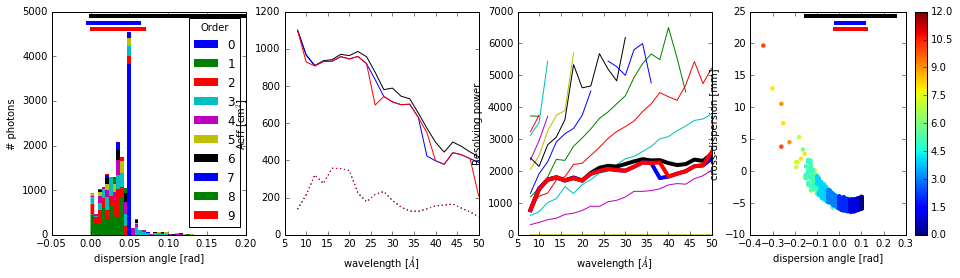

In [208]:
p = Table.read(filelist[0])
pclean, det_scenarios = make_det_scenarios(p)
fig = plot_everything(pclean, det_scenarios)

Blaze: 1.4 deg - d_channels:  600 mm - max_f:  11880 mm
circle r:   5948 mm - torus R:   5800 mm


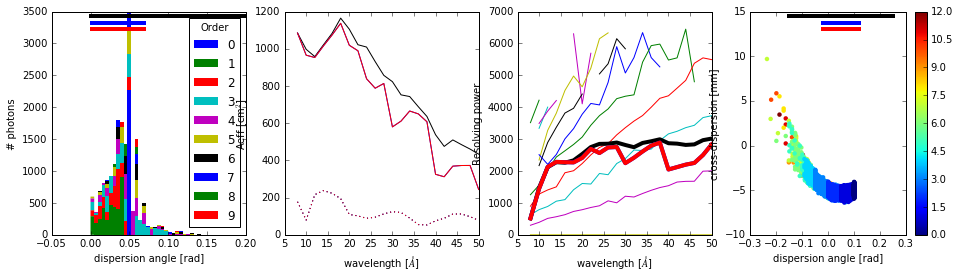

In [209]:
p = Table.read(filelist[2])
pclean, det_scenarios = make_det_scenarios(p)
fig = plot_everything(pclean, det_scenarios)

Blaze: 1.6 deg - d_channels:  600 mm - max_f:  11880 mm
circle r:   5948 mm - torus R:   5800 mm


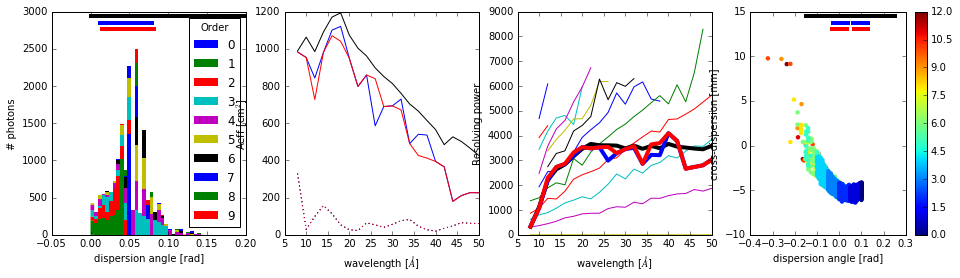

In [210]:
p = Table.read(filelist[4])
pclean, det_scenarios = make_det_scenarios(p)
fig = plot_everything(pclean, det_scenarios)

Blaze: 2.2 deg - d_channels:  600 mm - max_f:  11880 mm
circle r:   5948 mm - torus R:   5800 mm


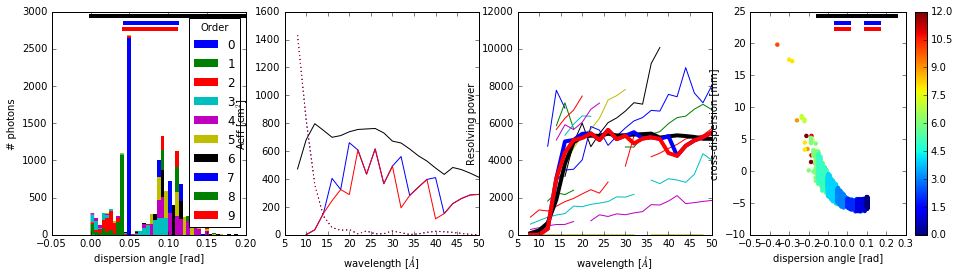

In [212]:
p = Table.read(filelist[10])
pclean, det_scenarios = make_det_scenarios(p)
fig = plot_everything(pclean, det_scenarios)